In [26]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter as savgol 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import umap
import networkx as nx
import gget
from sklearn import preprocessing

from pydmd import DMD

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# local imports
sys.path.append("../python/")

import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

<module 'hasnain_DMD' from '/home/cstansbu/git_repositories/DMD_gene/notebooks/../python/hasnain_DMD.py'>

In [2]:
fpath = f"/nfs/turbo/umms-indikar/shared/projects/myod/clean_data/time_series_rna_Z_scores.csv"
raw_path = f"/nfs/turbo/umms-indikar/shared/projects/myod/clean_data/time_series_rna.csv"

""" Load the raw expression """
exf = pd.read_csv(raw_path, index_col=0)
exf = exf.reset_index(drop=False)
exf['replicate'] = exf['index'].apply(lambda x: x.split("_")[1])
exf['time'] = exf['index'].apply(lambda x: x.split("_")[0].replace('T', ''))
print(f"{exf.shape=}")

"""Load the Z-score data frame """
df = pd.read_csv(fpath, index_col=0)
print(f"{df.shape=}")
gene_names = df.columns.to_list()
print(f"{len(gene_names)=}")

# create a replicate averaged dataset
mu_data = df.copy()

mu_data = mu_data.reset_index(drop=False)
mu_data['time'] = mu_data['index'].apply(lambda x: x.split("_")[0].replace("T", ""))
mu_data['time'] = mu_data['time'].astype(int)
mu_data = mu_data.drop(columns=['index'])

mu_data = mu_data.groupby('time').mean().reset_index(drop=False)
mu_data = mu_data.sort_values(by='time')
mu_data = mu_data.set_index('time')

"""Structure data for DMD """

mu_dmd = mu_data.to_numpy().T
dmd_data = np.expand_dims(mu_dmd, 2)

print(f"{dmd_data.shape=}")

exf.shape=(48, 23617)
df.shape=(48, 20967)
len(gene_names)=20967
dmd_data.shape=(20967, 16, 1)


# Perform DMD

NOTE, the first measurement is 48 hours before the second, so DMD should be performed on the
next 15 timepoints only

In [3]:
dmd_data = dmd_data[:, :15, :]
print(f"{dmd_data.shape=}")

dmd_data.shape=(20967, 15, 1)


In [4]:
rank = 14 # when None == optimal hard threshold  
exact = False # when false, this is exact DMD
dmd_res = hasnain_DMD.dmd(dmd_data, exact=exact, rank=rank)
print(dmd_res.keys())

print(f"{dmd_res['A'].shape=}")
print(f"{dmd_res['Atilde'].shape=}")
print(f"{dmd_res['u_r'].shape=}")
print(f"{dmd_res['L'].shape=}")
print(f"{dmd_res['W'].shape=}")
print(f"{dmd_res['Phi'].shape=}")
print(f"{dmd_res['amplitudes'][0].shape=}")

print('done')

dict_keys(['A', 'Atilde', 'rank', 'u_r', 'SVD', 'L', 'W', 'data_embedded', 'Phi', 'Phi_hat', 'amplitudes', 'n', 'm', 'r'])
dmd_res['A'].shape=(20967, 20967)
dmd_res['Atilde'].shape=(14, 14)
dmd_res['u_r'].shape=(20967, 14)
dmd_res['L'].shape=(14,)
dmd_res['W'].shape=(14, 14)
dmd_res['Phi'].shape=(20967, 14)
dmd_res['amplitudes'][0].shape=(14, 15)
done


(20967, 20967)
(93, 93)
(93, 94)


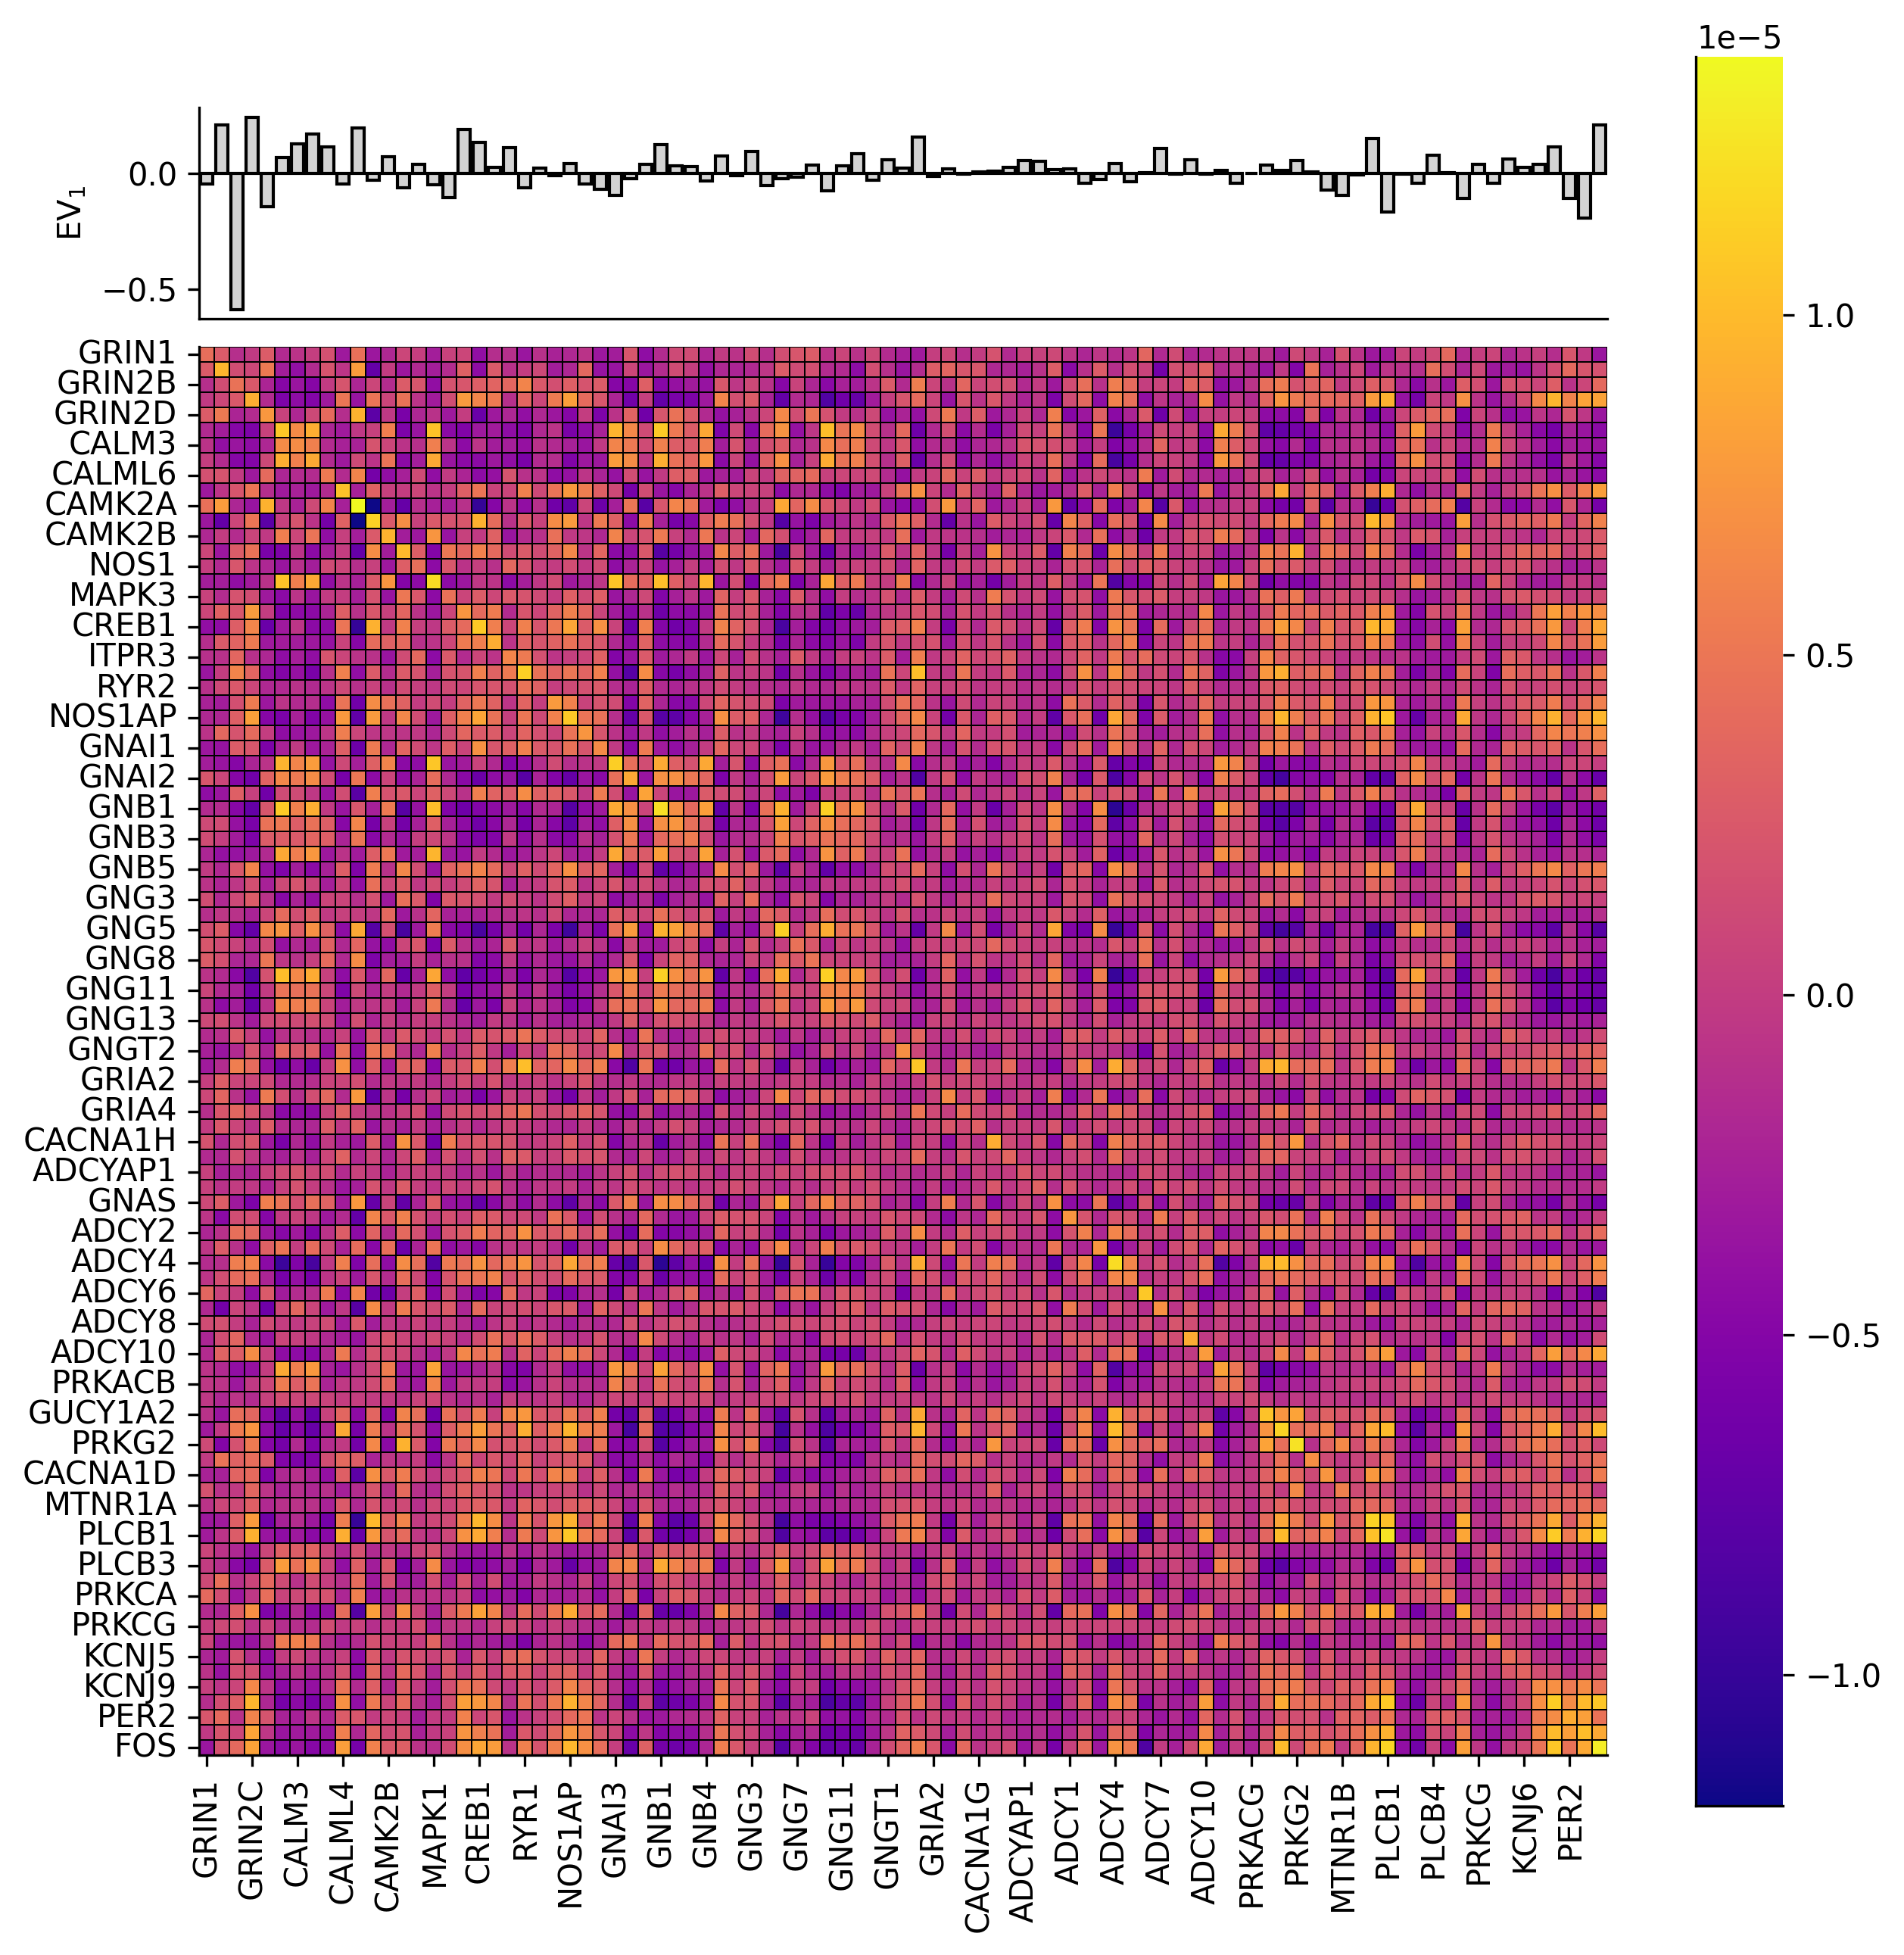

In [67]:
""" Play with the A matrix """

A = dmd_res['A']
print(f"{A.shape}")

# get pathway genes
pid = 'hsa04713'
genes = ut.parseKEGG(pid)
genes = [x for x in genes if x in gene_names]
ind = np.array([gene_names.index(x) for x in genes])

Ahat = A[ind, :][:, ind]
Ahat = Ahat @ Ahat.T
Ahat = pd.DataFrame(Ahat, index=genes, columns=genes)


# L = scipy.sparse.csgraph.laplacian(Ahat.to_numpy(), normed=True)
# eig, vec = np.linalg.eigh(L)

# plt.plot(eig)
# scipy.sparse.csgraph.laplacian(csgraph, normed=False


print(f"{Ahat.shape}")

eig, vec = np.linalg.eigh(Ahat)
vec = pd.DataFrame(vec)
vec = vec.reset_index(drop=False)
print(vec.shape)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10

sns.heatmap(Ahat, 
            cmap='plasma',
            lw=0.1,
            linecolor='k',
            square=True)

ax = plt.gca()
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("top", size="15%", pad="2%")

colors = np.where(vec[0] > 0, 'g', 'r')

sns.barplot(data=vec,
            x='index',
            y=0,
            color='lightgrey',
            # color=colors,
            ec='k',
            ax=ax2)

ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.set_xlabel("")
ax2.set_ylabel(r"EV$_1$")

sns.despine()

In [6]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
def gram_matrix(A, x0, nT=50, reduced=True, projection_matrix=np.array([])):
    '''
    A: matrix representation of the Koopman operator
    x0: initial conditions from measurements
    nT: number of timepoints over which to compute the Gram matrix
    reduced: if True, will compute reduced G from reduced data and KO and will also return full G after inverse projection
    projection_matrix: the matrix used to project data and KO to low-dimensional space (first r eigenvectors of Data.T @ Data)
    Both A and x0 can be either the full dimensional data and KO or they can be the DMD projected data and KO
    If projected, then return both the projected G and the full G after inverting the projection
    If not projected, then compute full G (can be slow, especially if the data dimension exceeds a couple thousand)
    Furthermore, for sensor placement we need to compute the eigendecomposition of G, so having the reduced G is handy   
    '''

    # generate artificial initial conditions for robust optimization 
    # get the min and max of each gene's initial value
    x0min = np.min(x0, axis=1)
    x0max = np.max(x0, axis=1)
    # form a set of new initial conditions distributed uniformly from x0min to x0max
    numICs = x0.shape[0]
    x0uni = np.zeros((len(x0min),numICs))
    x0uni[:,0:x0.shape[1]] = deepcopy(x0)
    for ii in range(x0.shape[1], x0uni.shape[1]):
        x0tmp = np.random.uniform(x0min,x0max)
        x0uni[:,ii] = x0tmp

    G = np.zeros_like(A)
    for ii in range(nT):
        print(f"{ii}...")
        A_pow = np.linalg.matrix_power(A,ii)
        G += np.matmul( np.matmul(A_pow, x0uni), np.matmul(x0uni.T, A_pow.T) ) 
    # right eigenvectors of G (columns of V) are rows of the gene sampling matrix (or vector if just one eigvec kept)

    if reduced: 
        Gfull = np.matmul(np.matmul(projection_matrix, G), projection_matrix.T)
        return G, Gfull
    else: 
        return G # this is the full G, computed directly from full KO and data


A = dmd_res['Atilde']
u = dmd_res['u_r']
nT = 16
G, Gfull = gram_matrix(A, data_embedded[:,0,:], nT=nT, reduced=True, projection_matrix=u)
print(f"{G.shape=} {Gfull.shape=}")

In [ ]:
# compute eigendecomposition of the Gram matrices
# right eigenvectors of G (columns of V) are rows of the gene sampling matrix 
D, V = np.linalg.eig(G)
print(f"{D.shape=}{ V.shape=}")

In [ ]:
break

In [ ]:
U_r = dmd_res['u_r']
Atilde = dmd_res['Atilde']
rank = dmd_res['rank']

n, m, r = dmd_data.shape

# create a prediction object
X0 = np.zeros((rank, m, r))
print(f"{X0.shape=}")

for i in range(r):
    X0[:,:,i] = np.dot(U_r.T, dmd_data[:,:,i])

# make the predicitions
X_pred_red, cd_red = n_step_prediction(Atilde, X0, m, r)
print(f"{cd_red=:.3f} {X_pred_red.shape=}")

In [ ]:
break

In [ ]:
""" Another way"""

In [ ]:
W

# Error Plots

In [ ]:
# reshape the input
replicate = 2 # zero-indexed!
time = 10

X0 = dmd_data[:, 0, replicate]
Xf = dmd_data[:, time-1, replicate]

print(f"{X0.shape=}")
print(f"{Xf.shape=}")

Ahat = np.linalg.matrix_power(Atilde, time)
AhatExp = U_r@Ahat@U_r.T
print(f"{Ahat.shape=} {AhatExp.shape=}")

rec = np.dot(AhatExp, X0)
print(f"{rec.shape=}")

err = np.linalg.norm(rec - Xf)
score, pval = scipy.stats.pearsonr(rec, Xf)
print(f"Error: {err=:.3f}, correlation: {score=:.3f} ({pval=:3f})")

# dmd_data.shape

# n, m, r = dmd_data.shape
# # print(f"input {dmd_data.shape=} {n=} {m=} {r=}")
# X0 = dmd_data[:,:-1].reshape(n,(m-1)*r, order='F') 
# print(f"{X0.shape=}")

In [ ]:
replicate = 2 # zero-indexed!
time = 15

X0 = dmd_data[:, 0, replicate]

res = []

for t in np.linspace(0, time, time+1):

    # the expression at this time
    Xf = dmd_data[:, time-1, replicate]

    # the transition matrix
    Ahat = np.linalg.matrix_power(Atilde, int(t))
    AhatExp = U_r@Ahat@U_r.T

    rec = np.dot(AhatExp, X0)

    err = np.linalg.norm(rec - Xf)
    score, pval = scipy.stats.pearsonr(rec, Xf)

    row = {
        'time' : t,
        'error' : err,
        'score' : score,
        'pval' : pval,
    }

    res.append(row)


res = pd.DataFrame(res)

sns.lineplot(data=res, 
            x='time',
            y='error')


res.head()

In [ ]:
break

In [ ]:
break

In [ ]:
break

In [ ]:
""" plot reconstruction error """

In [ ]:
""" Cluster genes based on the temporal modes """
